Arquivo 'phase2_results.csv' carregado com sucesso!

📋 Tabela de Resumo Quantitativo (Média de Performance) 📋


condition,baseline_normal,high_skewness,outliers_10_percent,small_samples
gladiator,,,,
ANOVA,1.000,1.000,0.858,1.000
Kruskal-Wallis,1.000,1.000,1.000,0.999
RandomForest,0.999,0.999,0.999,1.000
XGBoost,0.985,0.984,0.974,0.951


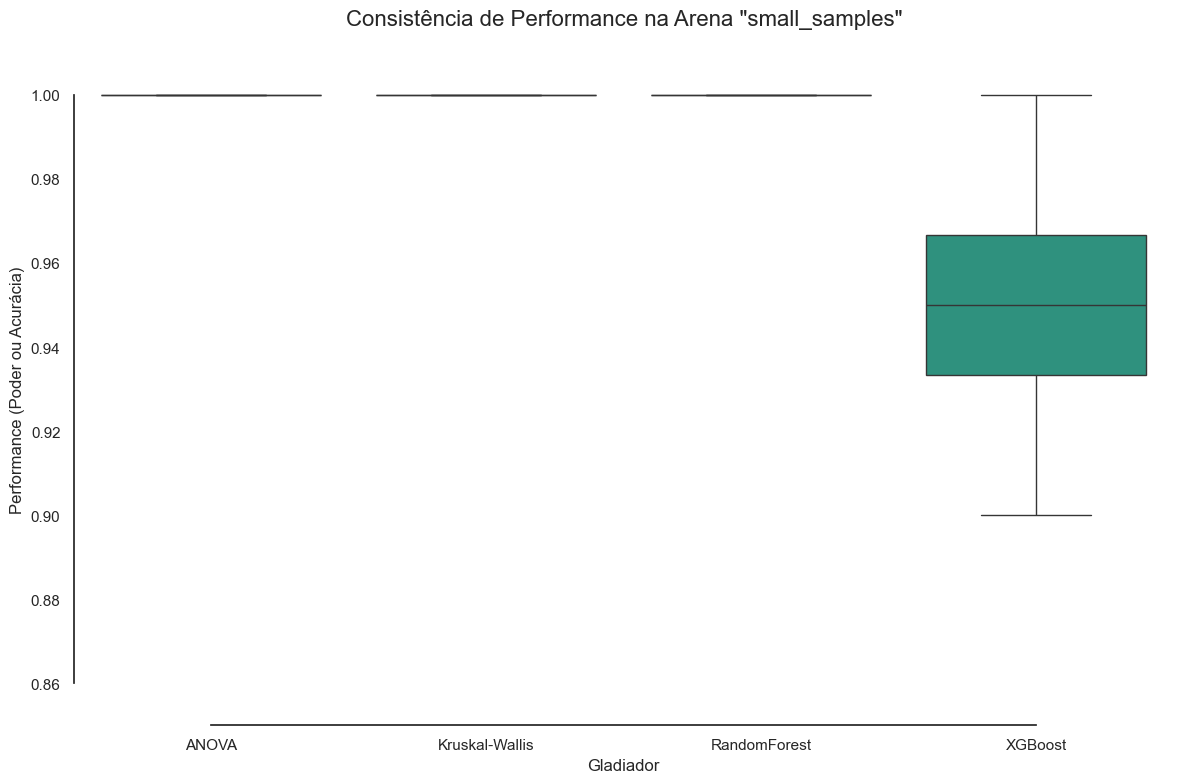


⚡ Executando Análise de Sensibilidade a Outliers... (2400 batalhas)


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm  # Barra de progresso para notebooks

# --- 1. SETUP E CARREGAMENTO ---
# Define um estilo mais limpo e acadêmico para todos os gráficos
plt.style.use('seaborn-v0_8-ticks')
sns.set_palette("viridis")

# Carregar os resultados completos da simulação
try:
    results_df = pd.read_csv('phase2_results.csv')
    print("Arquivo 'phase2_results.csv' carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo 'phase2_results.csv' não encontrado.")
    exit()

# --- 2. ANÁLISE QUANTITATIVA AVANÇADA (COM INTERVALO DE CONFIANÇA) ---
# Função para calcular a média e o IC de 95%
def get_performance_summary(data):
    if data.empty:
        return np.nan, np.nan, np.nan
    mean = data.mean()
    # Calcula o erro padrão da média e o intervalo de confiança
    sem = stats.sem(data)
    ci = sem * stats.t.ppf((1 + 0.95) / 2., len(data)-1)
    return mean, mean - ci, mean + ci

# Agrupando e calculando as métricas para a tabela final
summary_stats = []
for group_keys, group_df in results_df.groupby(['condition', 'gladiator']):
    condition, gladiator = group_keys
    
    metric_col = 'p_value' if 'p_value' in group_df.columns and group_df['p_value'].notna().any() else 'accuracy'
    
    if metric_col == 'p_value':
        performance_data = (group_df[metric_col] < 0.05).astype(int)
        metric_name = 'Power'
    else:
        performance_data = group_df[metric_col]
        metric_name = 'Avg. Accuracy'
        
    mean, ci_lower, ci_upper = get_performance_summary(performance_data)
    summary_stats.append({
        'condition': condition,
        'gladiator': gladiator,
        'metric': metric_name,
        'performance': mean,
        'ci_95_lower': ci_lower,
        'ci_95_upper': ci_upper
    })

summary_df = pd.DataFrame(summary_stats)
summary_pivot = summary_df.pivot_table(index='gladiator', columns='condition', values='performance')

print("\n📋 Tabela de Resumo Quantitativo (Média de Performance) 📋")
display(summary_pivot.style.format("{:.3f}"))


# --- 3. GRÁFICO BOXPLOT APRIMORADO (DEEP DIVE: SMALL SAMPLES) ---
small_sample_condition = 'small_samples'
small_sample_df = results_df.loc[results_df['condition'] == small_sample_condition].copy()
small_sample_df['performance'] = np.where(small_sample_df['p_value'].notna(), 
                                          (small_sample_df['p_value'] < 0.05).astype(int), 
                                          small_sample_df['accuracy'])

fig, ax = plt.subplots(figsize=(12, 8))
# Corrigindo o warning e usando um boxplot
sns.boxplot(data=small_sample_df, x='gladiator', y='performance', hue='gladiator', ax=ax, legend=False)

ax.set_title(f'Consistência de Performance na Arena "{small_sample_condition}"', fontsize=16, pad=20)
ax.set_xlabel('Gladiador', fontsize=12)
ax.set_ylabel('Performance (Poder ou Acurácia)', fontsize=12)
# Dando "zoom" no eixo Y para destacar as diferenças no topo
ax.set_ylim(0.85, 1.01)
sns.despine(trim=True) # Remove as bordas superiores e direitas do gráfico
plt.tight_layout()
plt.show()


# --- 4. GRÁFICO DE LINHAS (ANÁLISE DE SENSIBILIDADE A OUTLIERS) ---
# Micro-simulação para gerar os dados para o gráfico de linha
from simulation_engine import generate_battle_data
from scipy.stats import f_oneway, kruskal

contamination_levels = np.linspace(0, 0.25, 6) # De 0% a 25% de contaminação
sensitivity_results = []
n_runs_per_level = 200 # Simulação menor para agilidade

print(f"\n⚡ Executando Análise de Sensibilidade a Outliers... ({len(contamination_levels) * n_runs_per_level * 2} batalhas)")
for level in tqdm(contamination_levels):
    for i in range(n_runs_per_level):
        df = generate_battle_data(n_groups=3, n_per_group=30, effect_size=0.8, contamination_level=level, random_state=i)
        
        # ANOVA
        _, p_anova = f_oneway(*[df['value'][df['group'] == g] for g in df['group'].unique()])
        sensitivity_results.append({'contamination': level, 'gladiator': 'ANOVA', 'power': p_anova < 0.05})
        
        # Kruskal-Wallis
        _, p_kruskal = kruskal(*[df['value'][df['group'] == g] for g in df['group'].unique()])
        sensitivity_results.append({'contamination': level, 'gladiator': 'Kruskal-Wallis', 'power': p_kruskal < 0.05})

sensitivity_df = pd.DataFrame(sensitivity_results)

# Plotando o gráfico de linhas
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=sensitivity_df, x='contamination', y='power', hue='gladiator', style='gladiator', markers=True, dashes=False, ax=ax, errorbar='ci')

ax.set_title('Análise de Sensibilidade: Performance vs. Nível de Outliers', fontsize=16, pad=20)
ax.set_xlabel('Nível de Contaminação por Outliers', fontsize=12)
ax.set_ylabel('Poder Estatístico (Taxa de Detecção)', fontsize=12)
ax.set_xticks(contamination_levels)
ax.set_xticklabels([f'{x:.0%}' for x in contamination_levels])
ax.legend(title='Gladiador', fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()